In [145]:
import os
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfea
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from matplotlib.colors import CSS4_COLORS
from matplotlib.patches import Rectangle

In [170]:
root_dir = '/home/kajiyama/H08/H08_20230612'
rivnxl_path = f"{root_dir}/map/out/riv_nxl_/rivnxl.CAMA.tk5"
rivnum_path = f"{root_dir}/map/out/riv_num_/rivnum.CAMA.tk5"
rivara_path = f"{root_dir}/map/out/riv_ara_/rivara.CAMA.tk5"
lndmsk_path = f"{root_dir}/map/dat/lnd_msk_/lndmsk.CAMA.tk5"
rivmou_path = f"{root_dir}/map/out/riv_mou_/rivmou.CAMA.tk5"
nx, ny = 36, 48
tk5shape = (48, 36)

In [147]:
g_rivnxl = np.fromfile(rivnxl_path, 'float32').reshape(tk5shape)
g_rivnxl = np.ma.masked_where(g_rivnxl >= 1e20, g_rivnxl)
g_rivnxl = np.ma.masked_where(~np.isfinite(g_rivnxl) | (g_rivnxl == 0), g_rivnxl)

g_rivnum = np.fromfile(rivnum_path, 'float32').reshape(tk5shape)
g_rivnum = np.ma.masked_where(g_rivnum >= 1e20, g_rivnum)
g_rivnum = np.ma.masked_where(~np.isfinite(g_rivnum) | (g_rivnum == 0), g_rivnum)

g_rivara = np.fromfile(rivara_path, 'float32').reshape(tk5shape)
g_rivara = np.ma.masked_where(g_rivara >= 1e20, g_rivara)
g_rivara = np.ma.masked_where(~np.isfinite(g_rivara) | (g_rivara == 0), g_rivara)

g_lndmsk = np.fromfile(lndmsk_path, 'float32').reshape(tk5shape)

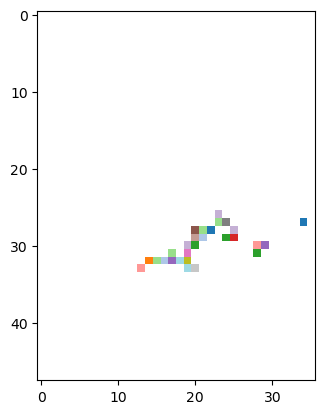

In [148]:
dtype = [('rivara', 'float32'), ('rivnum', 'float32')]
g_ara_num = np.empty(g_rivara.shape, dtype=dtype)
g_ara_num['rivara'] = g_rivara
g_ara_num['rivnum'] = g_rivnum
rivmou_estimated = np.ma.masked_all(g_ara_num.shape, dtype='float32')

unique_values, counts = np.unique(g_rivnum.compressed(), return_counts=True)
value_counts_dict = dict(zip(unique_values, counts))

for rivnum_id in value_counts_dict.keys():
    matching_positions = np.where(g_ara_num['rivnum'] == rivnum_id)
    max_rivara_postion = np.argmax(g_ara_num['rivara'][matching_positions])
    rivmou_estimated[matching_positions[0][max_rivara_postion], matching_positions[1][max_rivara_postion]] = rivnum_id

plt.imshow(rivmou_estimated, cmap='tab20')
# tone river = 848
# tone river river mouse xy coordinate is 34, 27

In [149]:
def l_coordinate_to_tuple(lcoordinate, a=48, b=36):
    lat_l = ((lcoordinate - 1) // b)
    lon_l = (lcoordinate) % b - 1
    return (lat_l, lon_l)

# l coordinate >>> xy coordinate
vfunc = np.vectorize(l_coordinate_to_tuple, otypes=[tuple])
result = np.empty(g_rivnxl.shape, dtype=tuple)
mask = ~np.isnan(g_rivnxl)
result[mask] = vfunc(g_rivnxl[mask])

# make result_array (48, 36, 2) with xy mesh data
result_list = []
for row in result:
    for x, y in row:
        result_list.append((x, y))
result_shape = (result.shape[0], result.shape[1], 2)
result_array = np.array(result_list).reshape(result_shape)
result_array = result_array.astype(int)

# prepare empty variables
result_dict = {}
unique_ids = np.unique(rivmou_estimated.compressed())
riv_path_array = np.ma.masked_all(rivmou_estimated.shape, dtype='float32')
visited_coords = set()

# basin number loop
for uid in unique_ids:
    coords_a = np.argwhere(rivmou_estimated == uid)
    riv_path_array[coords_a[0][0], coords_a[0][1]] = uid
    if coords_a.size > 0:
        target_coord = tuple(coords_a[0])
        path_coords = [target_coord]
        for _ in range(300):
            if target_coord in visited_coords:
                break
            visited_coords.add(target_coord)
            matched_coords = np.argwhere(np.all(target_coord == result_array, axis=2))
            if len(matched_coords) == 0:
                break
            # choose max rivara among mached indicies
            unvisited_matched = [tuple(coord) for coord in matched_coords if tuple(coord) not in visited_coords]
            if not unvisited_matched:
                break
            rivara_values = [g_rivara_cropped[coord[0], coord[1]] for coord in unvisited_matched]
            max_index = np.argmax(rivara_values)
            best_coord = unvisited_matched[max_index]
            riv_path_array[best_coord[0], best_coord[1]] = uid
            target_coord = best_coord
            path_coords.append(target_coord)
        result_dict[uid] = path_coords

In [151]:
def get_unique_non_masked_values(values):
    result = []
    for value in np.unique(values):
        if value is not np.ma.masked and not np.isnan(value):
            result.append(value)
    return result

def is_whiteish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    return (r + g + b) / 3 > 230  # Check if the average is above the threshold

def is_grayish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    deviation = max(r, g, b) - min(r, g, b)
    return deviation <= 20

def is_blueish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    return  b - r > 120 and b - g > 120  # If blue is dominant and significantly larger

def get_filtered_colors(all_colors):
    result = []
    for color in all_colors:
        if color != '#00FFFF' and not is_whiteish(color) and not is_grayish(color) and not is_blueish(color):
            result.append(color)
    return result

def make_cmap(Rivnum_masked_array):
    # ユニークな流域の数をカウント
    unique_values = get_unique_non_masked_values(Rivnum_masked_array)
    num_colors = len(unique_values)

    # 流域に固有の色を割り振る
    all_colors = list(CSS4_COLORS.values())
    filtered_colors = get_filtered_colors(all_colors)
    colors_list = filtered_colors[:num_colors]

    # -1<=x<0に透明色を追加
    colors_list.insert(0, '#00000000')

    # HTMLカラーコードに変化してlisted colormap を作成
    cmap = ListedColormap(colors_list)

    # [辞書作る] key=流域ID, value=0から数えたindex　
    index_dict = {}
    for i, value in enumerate(unique_values):
        index_dict[value] = i

    return num_colors, index_dict, cmap

def get_index(val, index_dict):
    return index_dict.get(val, -1)  # nan or unexpected values are mapped to -1

{848.0: 0, 2718.0: 1, 4850.0: 2, 6065.0: 3, 9986.0: 4, 15751.0: 5, 15960.0: 6, 17295.0: 7, 17857.0: 8, 18150.0: 9, 18399.0: 10, 20039.0: 11, 23349.0: 12, 24215.0: 13, 25821.0: 14, 29244.0: 15, 30199.0: 16, 31600.0: 17, 33061.0: 18, 33105.0: 19, 35993.0: 20, 39883.0: 21, 42814.0: 22, 48023.0: 23, 51027.0: 24, 57124.0: 25, 65176.0: 26, 67583.0: 27}


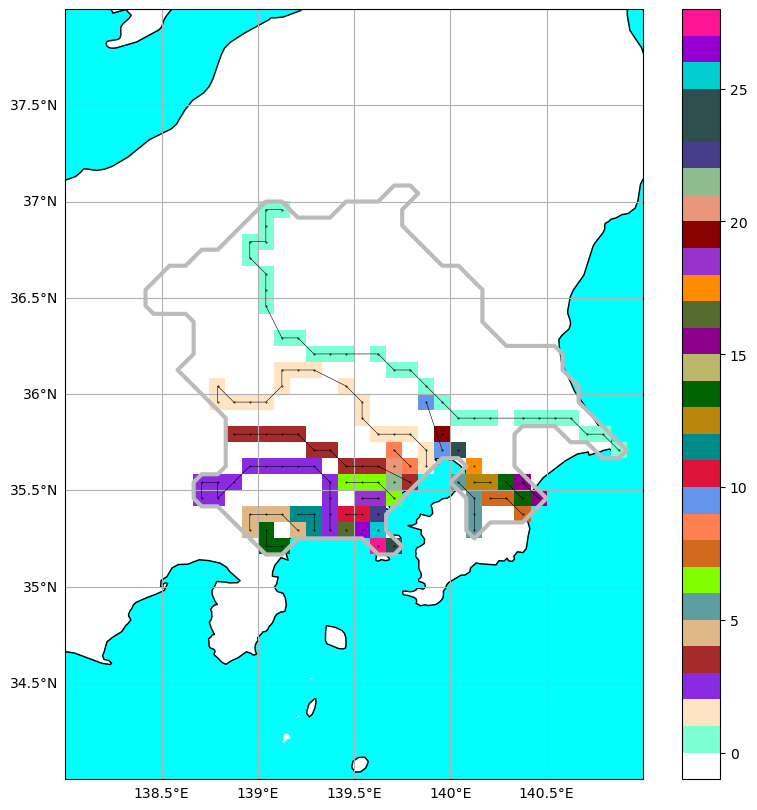

In [168]:
def path_zorder(data, g_mask_cropped, Rivnum_masked_array, result_dict):
    data = np.where(data<1e20, data, -1)
    
    num_colors, index_dict, cmap = make_cmap(Rivnum_masked_array)
    print(index_dict)
    
    indexed_data = np.vectorize(get_index)(data, index_dict)
    
    fig = plt.figure(figsize=(10, 10))
    projection = ccrs.PlateCarree()
    lonmin_tk5, lonmax_tk5, latmin_tk5, latmax_tk5 = 138, 141, 34, 38
    extent = (lonmin_tk5, lonmax_tk5, latmin_tk5, latmax_tk5)
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    ax.set_extent(extent, projection)
    light_gray = '#BBBBBB'
    
    contour = ax.contour(g_mask_cropped, levels=[0.5], colors=light_gray, linewidths=3, origin='upper', extent=extent, transform=projection, zorder=10)
    
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    ax.add_feature(cfea.OCEAN, color='#00FFFF')
    ax.add_feature(cfea.LAKES, color='#00FFFF')
    
    img = ax.imshow(indexed_data, extent=extent, transform=projection, cmap=cmap, vmin=-1, vmax=num_colors, zorder=2)
    
    one = 138
    two = 141
    three = 34
    four = 38
    
    if result_dict is not None:
        for key, path in result_dict.items():
            lat_coords, lon_coords = zip(*path)
            
            # xy coordinate >>> lonlat coordinate
            lat_coords = [(four - lat/12 - 1/24) for lat in lat_coords]
            lon_coords = [(one + lon/12 + 1/24) for lon in lon_coords]
            ax.plot(lon_coords, lat_coords, marker='o', markersize=0.4, color='black', linestyle='-', linewidth=.4, transform=projection, zorder=5)
            
    fig.colorbar(img, ax=ax)

path_zorder(riv_path_array, g_mask_cropped, g_rivnum, result_dict)